# Predicting Olympic medal tables
**Ideas for features:**
- **Population** four years earlier (assumes a 4yr cycle)
- **GDP per capita** (assumes a 4yr cycle)
- **Host Nation** (host nations tend to invest more, have a home crowd, can take more athletes)-->EXTENSION: investigate Tokyo where home crowd was less
- **Medals available per country** (total number of medals awarded at a games / number of countries competing)
- **Medals won at last games** (Gives indication of prior success. How should this account for geopolitical changes, such as USSR-->Russian Federation)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from math import ceil, floor
from tqdm import tqdm
import os

plt.style.use('seaborn-whitegrid')

max_rows = pd.get_option('display.max_rows')
max_cols = pd.get_option('display.max_columns')

## Load data, set target variable and features

In [4]:
project_path = r'C:\Users\tmais\Documents\Coding\Python\Projects\ML\OlympicsResults'
oly_fname = r'olympics_summer_features.csv'
oly_raw = pd.read_csv(os.path.join(project_path, oly_fname))
oly = oly_raw.copy()
oly_raw.head()

,games,country,alpha_3,ioc_code,host,year,gold,silver,bronze,total,...,games_silver,games_bronze,games_medals,n_teams,medals_per_team,past_tot_1,past_tot_2,past_tot_3,past_tot_4,past_tot_5
0,Athens 1896,Australia,AUS,AUS,0,1896,2,0,0,2,...,43,36,122,16,7.625,NaN,NaN,NaN,NaN,NaN
1,Athens 1896,Austria,AUT,AUT,0,1896,2,1,2,5,...,43,36,122,16,7.625,NaN,NaN,NaN,NaN,NaN
2,Athens 1896,Bulgaria,BGR,BUL,0,1896,0,0,0,0,...,43,36,122,16,7.625,NaN,NaN,NaN,NaN,NaN
3,Athens 1896,Chile,CHL,CHI,0,1896,0,0,0,0,...,43,36,122,16,7.625,NaN,NaN,NaN,NaN,NaN
4,Athens 1896,Denmark,DNK,DEN,0,1896,1,2,3,6,...,43,36,122,16,7.625,NaN,NaN,NaN,NaN,NaN


In [5]:
oly.shape

(2996, 49)

### Select Features for Modelling

In [6]:
target = 'total'
features = ['pop_8', 'gdppc_4', 'host_0', 'medals_per_team', 'past_tot_1']
tgt_feat = [target]
tgt_feat.extend(features)
tgt_feat

['total', 'pop_8', 'gdppc_4', 'host_0', 'medals_per_team', 'past_tot_1']

### Drop old games data

In [7]:
oly = oly[oly.year>=1980]
oly.shape

(1975, 49)

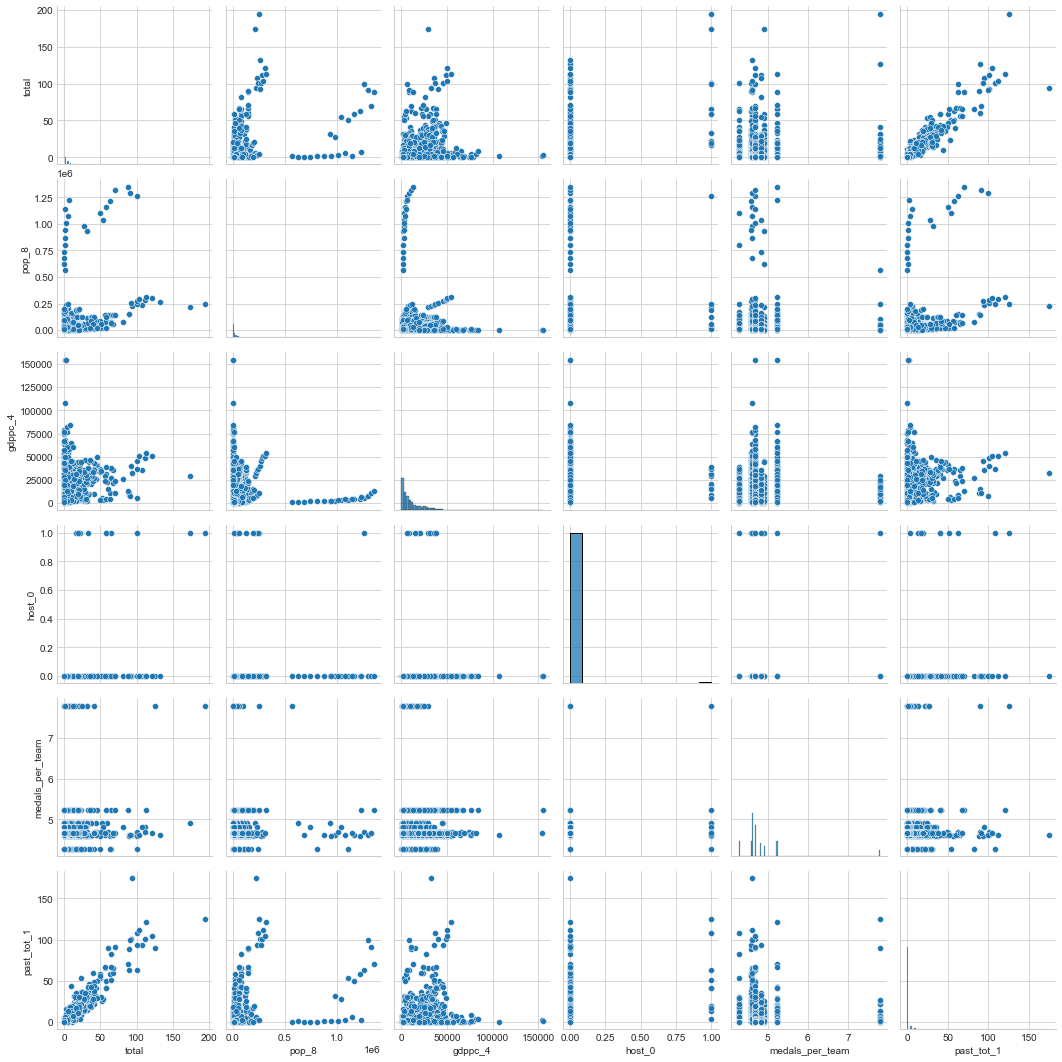

In [8]:
sns.pairplot(data=oly, vars=tgt_feat)

### Drop nans

<AxesSubplot:>

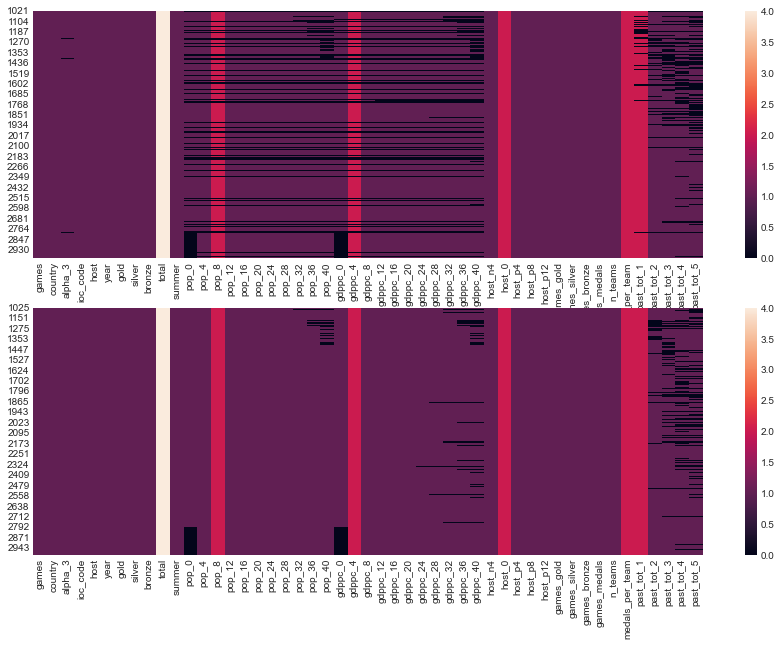

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

mask1 = data=oly.isna().replace({True: 0, False: 1})
mask1[features] = mask1[features] * 2
mask1[target] = mask1[target] * 4

oly = oly.dropna(subset=tgt_feat)

mask2 = data=oly.isna().replace({True: 0, False: 1})
mask2[features] = mask2[features] * 2
mask2[target] = mask2[target] * 4

sns.heatmap(mask1, ax=ax[0])
sns.heatmap(mask2, ax=ax[1])

In [10]:
oly.shape

(1464, 49)

## Modelling Setup

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold, RandomizedSearchCV, GridSearchCV

from sklearn.inspection import permutation_importance

from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import VerboseCallback, DeltaYStopper
from skopt import BayesSearchCV

Set default parameters for reuse across models etc

In [12]:
error_score = 'neg_root_mean_squared_error'
# error_score = 'neg_mean_absolute_error'
test_size = 0.25
random_seed = 0
k_fold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
k_fold_repeat = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

results = []

In [13]:
X_train, X_test, y_train, y_test = train_test_split(oly[features],
                                                    oly[target],
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [14]:
oly['test'] = 0
oly.loc[y_test.index,'test'] = 1
oly[['games', 'country'] + features + [target, 'test']].head()

C:\Users\tmais\AppData\Local\Temp/ipykernel_26316/2898403250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oly['test'] = 0
C:\Users\tmais\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,games,country,pop_8,gdppc_4,host_0,medals_per_team,past_tot_1,total,test
1025,Moscow 1980,Australia,13177.0,21613.0,0,7.790123,5.0,9,0
1026,Moscow 1980,Austria,7544.0,19448.0,0,7.790123,1.0,4,1
1027,Moscow 1980,Belgium,9709.0,20916.0,0,7.790123,6.0,1,1
1030,Moscow 1980,Brazil,100874.0,7079.0,0,7.790123,2.0,4,0
1031,Moscow 1980,Bulgaria,8576.0,9535.0,0,7.790123,22.0,41,1


### Utility Functions

In [15]:
def train_test_error(model, X_train, y_train, X_test, y_test, scoring='neg_mean_absolute_error'):
    '''Calculate error score for train and test sets to help identify overfitting'''
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    if scoring=='neg_mean_absolute_error':
        err_train = mean_absolute_error(y_pred=y_pred_train, y_true=y_train)
        err_test = mean_absolute_error(y_pred=y_pred_test, y_true=y_test)
    elif scoring=='neg_root_mean_squared_error':
        err_train = np.sqrt(mean_squared_error(y_pred=y_pred_train, y_true=y_train))
        err_test = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_test))
    
    return err_train, err_test

In [16]:
def scores_to_df(scores, params, var_name, score_name='mae'):
    '''Convert list of cross-val score arrays into dataframe for plotting in seaborn'''
    s = {}
    for i, param in enumerate(params):
        try:
            param = round(param, 3)
        except:
            pass
        s[str(param)] = np.absolute(scores[i])
    s = pd.DataFrame(s).melt(var_name=var_name, value_name=score_name)
    return s

In [17]:
def assess_model_param(model, params, X, y, cv=k_fold):
    initial_params = model.get_params()
    param_name = list(params.keys())[0]
    scores, errors = [], []
    model_name = model.__class__.__name__
    print(f'{model_name} {error_score}')
    for param in params[param_name]:
        kwarg = {}
        kwarg[param_name] = param
        model.set_params(**kwarg)

        # cross validation
        scores_ = cross_val_score(model, X, y, cv=cv, scoring=error_score, n_jobs=-1)
        score_mean = np.mean(scores_)
        score_std = np.std(scores_)
        scores.append(scores_)

        # train vs test
        model.fit(X_train, y_train)
        err_train, err_test = train_test_error(model, X_train, y_train, X_test, y_test)
        errors.append([err_train, err_test])
        
        try:
            param = round(param, 3)
        except:
            pass

        print((f'{param_name} {param}:\t{score_mean:.3f} (std {score_std:.3f})'
               f' | train err: {err_train:.3f}, test err: {err_test:.3f}'))

    # plot results
    s = scores_to_df(scores, params=params[param_name], var_name=param_name, score_name=error_score)
    sns.lineplot(x=param_name, y=error_score, data=s)
    plt.title(model_name)
    #plt.ylim([0, s[error_score].max()])
    
    # reset model parameters to initial values
    model.set_params(**initial_params)
    
    return scores, errors

In [18]:
def model_fit_plot(model, X_train, y_train, X_test, y_test, bias_adjust=1):
    ''' Function that produces a scatter plot for train and test data '''
    
    fig, ax = plt.subplots(figsize=(7, 7))
    
    plt.scatter(model.predict(X_train) * bias_adjust, y_train)
    plt.scatter(model.predict(X_test) * bias_adjust, y_test)
    
    plt.xlabel('Prediction')
    plt.ylabel('True Values')
    
    lim = max(y_train.max(), y_test.max()) * 1.05
    plt.xlim([0, lim])
    plt.ylim([0, lim])
    
    plt.title(f'{model.__class__.__name__}: Train vs Test Predictions')
    plt.legend(['Train', 'Test'])

## Linear Model

### Spot test model with CV Score

## Random Forest

### Spot-Check Model

In [19]:
rf = RandomForestRegressor(random_state=random_seed)

model_name = rf.__class__.__name__
cv = k_fold_repeat
rf_cv = np.mean(cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1, scoring=error_score))

rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

rf_initial_err_train, rf_initial_err_test = train_test_error(rf, X_train, y_train, X_test, y_test, scoring=error_score)

print((f'{model_name} ({error_score})\n'
       f'{error_score} ({cv}-fold CV): {np.mean(rf_cv):.3f}\n'
       f'Train: {rf_initial_err_train}\nTest: {rf_initial_err_test}'))

RandomForestRegressor (neg_root_mean_squared_error)
neg_root_mean_squared_error (RepeatedKFold(n_repeats=3, n_splits=10, random_state=0)-fold CV): -3.723
Train: 1.4447547235753413
Test: 3.695535188287192


Training error is much lower than test error, suggesting overfitting. Hyperparameter tuning should improve this.

### Testing Hyperparameters
Hyperparameter heuristics taken from <a href="https://machinelearningmastery.com/random-forest-ensemble-in-python/">Machine Learning Mastery</a>.

**Max Features per Split:** A good heuristic for regression is to set the features per split hyperparameter to 1/3 the number of input features.

RandomForestRegressor neg_root_mean_squared_error
max_features 1:	-4.426 (std 1.065) | train err: 0.757, test err: 2.109
max_features 2:	-3.731 (std 0.736) | train err: 0.695, test err: 1.908
max_features 3:	-3.651 (std 0.803) | train err: 0.659, test err: 1.835
max_features 4:	-3.703 (std 0.829) | train err: 0.671, test err: 1.857
max_features 5:	-3.737 (std 0.914) | train err: 0.676, test err: 1.825


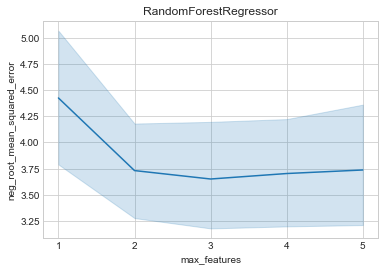

In [20]:
params = {'max_features': range(1,len(features)+1)}
rf_max_feature_scores, rf_max_feature_errors = assess_model_param(rf, params, X_train, y_train)

Variation isn't large but it seems that max_features of 2 or 3 seems to be best for both CV and train/test

**Number of trees:** Increase until performance stabilises

RandomForestRegressor neg_root_mean_squared_error
n_estimators 10:	-3.868 (std 1.039) | train err: 0.738, test err: 1.936
n_estimators 50:	-3.769 (std 0.928) | train err: 0.677, test err: 1.835
n_estimators 100:	-3.737 (std 0.914) | train err: 0.676, test err: 1.825
n_estimators 200:	-3.737 (std 0.908) | train err: 0.671, test err: 1.816
n_estimators 500:	-3.749 (std 0.896) | train err: 0.668, test err: 1.818
n_estimators 1000:	-3.748 (std 0.889) | train err: 0.663, test err: 1.825
n_estimators 2000:	-3.744 (std 0.891) | train err: 0.663, test err: 1.825


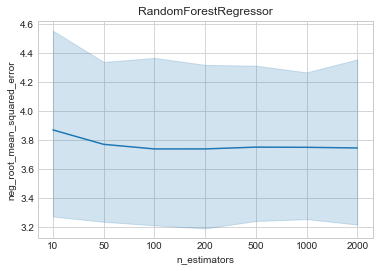

In [21]:
params = {'n_estimators': [10, 50, 100, 200, 500, 1000, 2000]}
rf_n_estimators_scores, rf_n_estimators_errors = assess_model_param(rf, params, X_train, y_train)

Performance plateaus between 500 and 1000. Could explore points around 1000 for tuning.

**Max Depth:** Explore range (low values seem appropriate for this data)

RandomForestRegressor neg_root_mean_squared_error
max_depth 1:	-6.938 (std 1.838) | train err: 3.928, test err: 4.273
max_depth 3:	-3.753 (std 0.953) | train err: 1.665, test err: 2.016
max_depth 5:	-3.690 (std 0.915) | train err: 1.384, test err: 1.784
max_depth 7:	-3.706 (std 0.923) | train err: 1.120, test err: 1.805
max_depth 9:	-3.744 (std 0.911) | train err: 0.929, test err: 1.809
max_depth 11:	-3.731 (std 0.904) | train err: 0.806, test err: 1.812
max_depth 13:	-3.743 (std 0.888) | train err: 0.733, test err: 1.821
max_depth 15:	-3.744 (std 0.884) | train err: 0.690, test err: 1.818
max_depth None:	-3.737 (std 0.914) | train err: 0.676, test err: 1.825


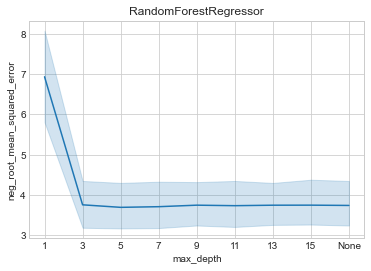

In [22]:
params = {'max_depth': list(range(1,16,2)) + [None]}
rf_max_depth_scores, rf_max_depth_errors = assess_model_param(rf, params, X_train, y_train)

Max depth min at 9, plateauing from there

**Max Samples:** % of data used in bootstrapping

RandomForestRegressor neg_root_mean_squared_error
max_samples 0.1:	-4.392 (std 1.257) | train err: 1.715, test err: 2.117
max_samples 0.2:	-3.806 (std 0.953) | train err: 1.506, test err: 1.986
max_samples 0.3:	-3.679 (std 0.812) | train err: 1.307, test err: 1.917
max_samples 0.4:	-3.679 (std 0.816) | train err: 1.208, test err: 1.887
max_samples 0.5:	-3.678 (std 0.871) | train err: 1.079, test err: 1.806
max_samples 0.6:	-3.717 (std 0.845) | train err: 0.968, test err: 1.827
max_samples 0.7:	-3.686 (std 0.844) | train err: 0.884, test err: 1.798
max_samples 0.8:	-3.661 (std 0.847) | train err: 0.814, test err: 1.806
max_samples 0.9:	-3.694 (std 0.874) | train err: 0.737, test err: 1.802
max_samples 1.0:	-3.737 (std 0.914) | train err: 0.676, test err: 1.825


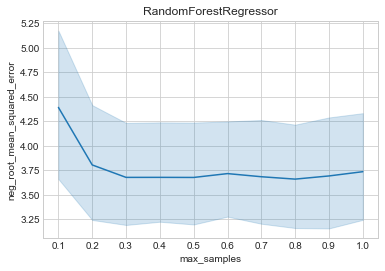

In [23]:
params = {'max_samples': np.arange(0.1, 1.1, 0.1)}
rf_max_samples_scores, rf_max_samples_errors = assess_model_param(rf, params, X_train, y_train)

Max samples at ~70% seems best

### Hyperparameter Tuning

In [24]:
rf = RandomForestRegressor(random_state=random_seed)

# set up parameter ranges
params = {'max_depth': (1, 20),
          'max_samples': (0.1, 1.0, 'uniform'),
          'max_features': (1, len(features)),
          'n_estimators': (10, 2000)}
# 'min_samples_leaf': [1, 2, 4]
# 'min_samples_split': [2, 5, 10]

# run hyperparameter optimisation
tuner = BayesSearchCV(estimator=rf,
                      search_spaces=params,
                      scoring=error_score,
                      n_iter=100,
                      cv=cv,
                      n_jobs=-1,
                      verbose=0,
                      random_state=random_seed)
t1 = time.time()
tuner.fit(X=X_train, 
          y=y_train,
          callback=[VerboseCallback(n_total=50), DeltaYStopper(n_best=5, delta=0.05)])

# print results
print(f'Search Time: {time.strftime("%H:%M:%S", time.gmtime(time.time()-t1))}')
print(f'Best {error_score}: {tuner.best_score_}')
print(tuner.best_params_)
rf_best = tuner.best_estimator_

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 29.9021
Function value obtained: 3.6379
Current minimum: 3.6379
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 26.7290
Function value obtained: 3.6752
Current minimum: 3.6379
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 6.6532
Function value obtained: 4.9808
Current minimum: 3.6379
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 15.6784
Function value obtained: 3.6770
Current minimum: 3.6379
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 10.9266
Function value obtained: 3.

In [25]:
rf_best_err_train, rf_best_err_test = train_test_error(rf_best, X_train, y_train, X_test, y_test, scoring=error_score)
print((f'{model_name} Best Model ({error_score})\n'
       f'Initial Error:\tTrain: {rf_initial_err_train:.3f}\tTest: {rf_initial_err_test:.3f}\n'
       f'Tuned Error:\tTrain: {rf_best_err_train:.3f}\tTest: {rf_best_err_test:.3f}'))

RandomForestRegressor Best Model (neg_root_mean_squared_error)
Initial Error:	Train: 1.445	Test: 3.696
Tuned Error:	Train: 1.981	Test: 3.800


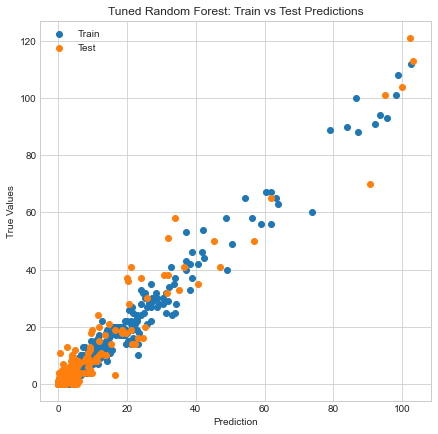

In [26]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.scatter(rf_best.predict(X_train), y_train)
plt.scatter(rf_best.predict(X_test), y_test)
plt.xlabel('Prediction')
plt.ylabel('True Values')
plt.title('Tuned Random Forest: Train vs Test Predictions')
plt.legend(['Train', 'Test'])

### Feature Importance

**Impurity Importance** (Default)

Text(0.5, 1.0, 'Tuned Random Forest: Impurity Feature Importances')

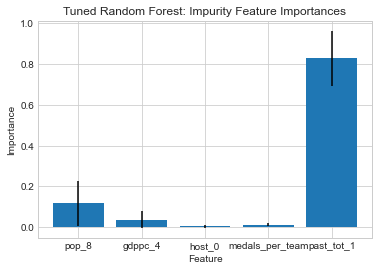

In [27]:
importances = rf_best.feature_importances_
importances_std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
plt.bar(features, importances, yerr=importances_std)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Tuned Random Forest: Impurity Feature Importances')

**Permutation Importance:** This approach is more reliable for high cardinality features but is slower to compute.

Text(0.5, 1.0, 'Tuned Random Forest: Permutations Feature Importances')

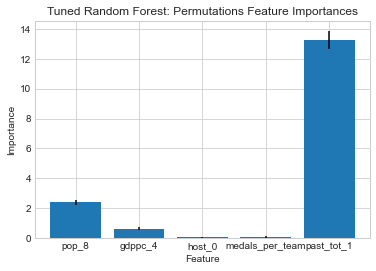

In [28]:
result = permutation_importance(rf_best, 
                                X_test, 
                                y_test, 
                                n_repeats=10, 
                                scoring=error_score,
                                random_state=random_seed, 
                                n_jobs=-1)
plt.bar(features, result.importances_mean, yerr=result.importances_std)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Tuned Random Forest: Permutations Feature Importances')

Population and GDP per captita are clearly the most important features for both metrics. Interestingly the Impurity approach doesn't penalise the host feature relative to the Permutations method (typically they bias high-cardinality features).

### Predictions vs Data

C:\Users\tmais\AppData\Local\Temp/ipykernel_26316/460040525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oly['random_forest'] = rf_best.predict(oly[features])
C:\Users\tmais\AppData\Local\Temp/ipykernel_26316/460040525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oly['random_forest'] = oly['random_forest'].astype('int')


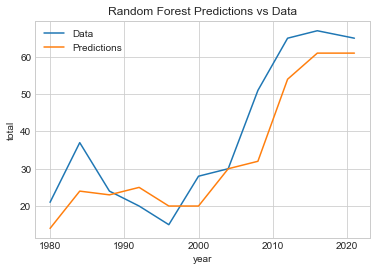

In [29]:
oly['random_forest'] = rf_best.predict(oly[features])
oly['random_forest'] = oly['random_forest'].astype('int')
df = oly.loc[oly.alpha_3=='GBR', ['games', 'country', 'ioc_code', 'year', 'total', 'random_forest']]
sns.lineplot(data=df, x='year', y='total')
sns.lineplot(data=df, x='year', y='random_forest')
plt.title('Random Forest Predictions vs Data')
plt.legend(['Data', 'Predictions'])

In [30]:
oly.loc[oly.alpha_3=='GBR', ['games', 'country', 'year'] + features + [target, 'test', 'random_forest']]

,games,country,year,pop_8,gdppc_4,host_0,medals_per_team,past_tot_1,total,test,random_forest
1046,Moscow 1980,Great Britain,1980,56079.0,19311.00,0,7.790123,13.0,21,1,14
1150,Los Angeles 1984,Great Britain,1984,56206.0,20612.00,0,4.914286,21.0,37,1,24
1300,Seoul 1988,Great Britain,1988,56314.0,21869.00,0,4.618750,37.0,24,0,23
1463,Barcelona 1992,Great Britain,1992,56462.0,25679.00,0,4.822485,24.0,20,1,25
1643,Atlanta 1996,Great Britain,1996,57160.0,25790.18,0,4.274112,20.0,15,0,20
1840,Sydney 2000,Great Britain,2000,57828.0,28472.25,0,4.611940,15.0,28,1,20
2042,Athens 2004,Great Britain,2004,58417.0,31946.04,0,4.584158,28.0,30,0,30
2243,Beijing 2008,Great Britain,2008,59145.0,34865.78,0,4.691176,30.0,51,1,32
2448,London 2012,Great Britain,2012,60245.0,36264.79,1,4.613527,51.0,65,0,54
2655,Rio 2016,Great Britain,2016,62072.0,35185.00,0,4.677885,65.0,67,0,61


## Gradient Boosting

### Spot-check model

In [31]:
model_name = 'Gradient Boosting'
gb = GradientBoostingRegressor(random_state=random_seed)
gb_cv = np.mean(cross_val_score(gb, X_train, y_train, cv=cv, scoring=error_score))
print(f'{model_name}\n{error_score} ({cv} fold CV): {np.mean(gb_cv)}')

Gradient Boosting
neg_root_mean_squared_error (RepeatedKFold(n_repeats=3, n_splits=10, random_state=0) fold CV): -3.5367842156493143


Initial CV error is slightly lower than the Random Forest

In [32]:
gb.fit(X_train, y_train)
y_pred_test = gb.predict(X_test)
y_pred_train = gb.predict(X_train)

gb_initial_err_train, gb_initial_err_test = train_test_error(gb, X_train, y_train, X_test, y_test, scoring=error_score)

print(f'{model_name} ({error_score})\nTrain: {gb_initial_err_train}\nTest: {gb_initial_err_test}')

Gradient Boosting (neg_root_mean_squared_error)
Train: 1.9847982697578792
Test: 3.678891289067609


Training error is lower than test error, suggesting overfitting (but less than for initial random forest). Hyperparameter tuning should improve this.

### Testing Hyperparameters


## XGBoost

### Spot-Check Model

XGBRegressor, CV: RepeatedKFold(n_repeats=3, n_splits=10, random_state=0)
neg_root_mean_squared_error: -3.937
Train: 0.3051896878188178
Test: 3.711970166583249


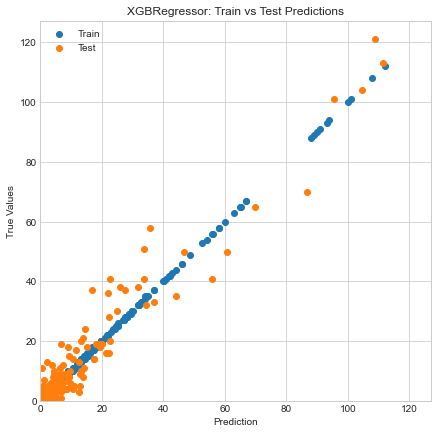

In [33]:
xgb = XGBRegressor(random_state=random_seed)
model_name = xgb.__class__.__name__
cv = k_fold_repeat
xgb_cv = np.mean(cross_val_score(xgb, X_train, y_train, cv=cv, n_jobs=-1, scoring=error_score))

xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

xgb_initial_err_train, xgb_initial_err_test = train_test_error(xgb, X_train, y_train, X_test, y_test, scoring=error_score)

print((f'{model_name}, CV: {cv}\n'
       f'{error_score}: {np.mean(xgb_cv):.3f}\n'
       f'Train: {xgb_initial_err_train}\nTest: {xgb_initial_err_test}'))

model_fit_plot(xgb, X_train, y_train, X_test, y_test)

XGBoost is heavily overfitted with default parameters!

### Testing Hyperparameters

In [34]:
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

**Number of trees:** Increase until performance stabilises

XGBRegressor neg_root_mean_squared_error
n_estimators 10:	-3.867 (std 1.079) | train err: 0.995, test err: 1.947
n_estimators 50:	-3.889 (std 1.042) | train err: 0.393, test err: 1.857
n_estimators 100:	-3.909 (std 1.041) | train err: 0.197, test err: 1.878
n_estimators 200:	-3.910 (std 1.037) | train err: 0.057, test err: 1.895
n_estimators 500:	-3.913 (std 1.035) | train err: 0.003, test err: 1.898
n_estimators 1000:	-3.913 (std 1.035) | train err: 0.002, test err: 1.899
n_estimators 2000:	-3.913 (std 1.035) | train err: 0.002, test err: 1.899


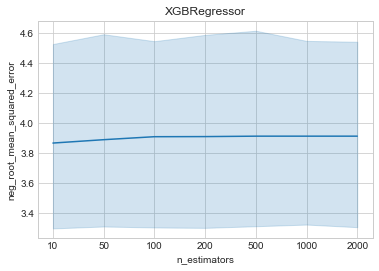

In [35]:
params = {'n_estimators': [10, 50, 100, 200, 500, 1000, 2000]}
xgb_n_estimators_scores, xgb_n_estimators_errors = assess_model_param(xgb, params, X_train, y_train)

Little trend here...

**Learning Rate:** Learning rate controls the amount of contribution that each model has on the ensemble prediction.

Smaller rates may require more decision trees in the ensemble.

The learning rate can be controlled via the “eta” argument and defaults to 0.3.

XGBRegressor neg_root_mean_squared_error
learning_rate 0.001:	-12.377 (std 3.073) | train err: 4.860, test err: 5.404
learning_rate 0.005:	-8.985 (std 2.244) | train err: 3.479, test err: 4.022
learning_rate 0.01:	-6.430 (std 1.642) | train err: 2.429, test err: 2.996
learning_rate 0.05:	-3.846 (std 1.050) | train err: 0.863, test err: 1.923
learning_rate 0.1:	-3.905 (std 1.012) | train err: 0.614, test err: 1.870
learning_rate 0.15:	-3.876 (std 0.992) | train err: 0.459, test err: 1.946
learning_rate 1.0:	-4.247 (std 0.984) | train err: 0.007, test err: 2.185


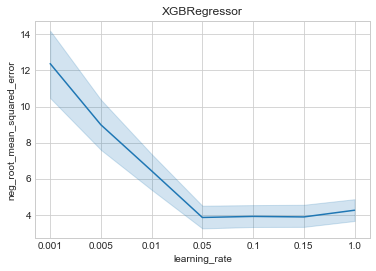

In [36]:
params = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 1.0]}
xgb_eta_scores, xgb_eta_errors = assess_model_param(xgb, params, X_train, y_train)

A learning rate ~0.05 seems best (with default 100 estimators).

**Max Depth:** Explore range (low values seem appropriate for this data)

XGBRegressor neg_root_mean_squared_error
max_depth 1:	-4.035 (std 1.017) | train err: 1.624, test err: 1.931
max_depth 3:	-3.603 (std 1.108) | train err: 0.811, test err: 1.883
max_depth 5:	-3.857 (std 1.086) | train err: 0.333, test err: 1.917
max_depth 7:	-3.871 (std 0.960) | train err: 0.109, test err: 2.013
max_depth 9:	-3.987 (std 0.977) | train err: 0.023, test err: 2.003
max_depth 11:	-3.951 (std 1.013) | train err: 0.004, test err: 1.969
max_depth 13:	-3.973 (std 1.001) | train err: 0.001, test err: 1.958
max_depth 15:	-4.009 (std 0.997) | train err: 0.001, test err: 1.978
max_depth None:	-4.009 (std 0.997) | train err: 0.001, test err: 1.978


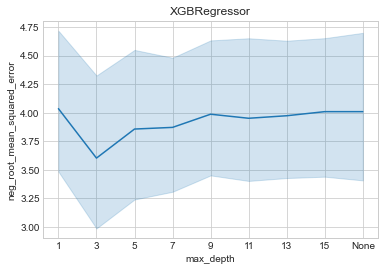

In [37]:
params = {'max_depth': list(range(1,16,2)) + [None]}
xgb_max_depth_scores, xgb_max_depth_errors = assess_model_param(xgb, params, X_train, y_train)

Max depth of 3 seems to be best, again, simpler than Random Forest.

**min_child_weight** Min sum of weights, prevents overfitting but can underfit if too large

XGBRegressor neg_root_mean_squared_error
min_child_weight 1:	-3.909 (std 1.041) | train err: 0.197, test err: 1.878
min_child_weight 5:	-3.683 (std 0.931) | train err: 0.353, test err: 1.883
min_child_weight 9:	-3.856 (std 0.941) | train err: 0.590, test err: 2.008
min_child_weight 13:	-3.964 (std 1.165) | train err: 0.779, test err: 1.866
min_child_weight 17:	-3.961 (std 0.866) | train err: 0.894, test err: 1.848


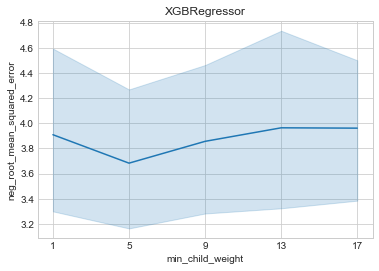

In [38]:
params = {'min_child_weight': list(range(1,20,4))}
xgb_min_child_weight_scores, xgb_min_child_weight_errors = assess_model_param(xgb, params, X_train, y_train)

5 performs best

**Subsample:** Percentage of data sampled for each new tree

XGBRegressor neg_root_mean_squared_error
subsample 0.1:	-4.355 (std 0.680) | train err: 1.469, test err: 2.385
subsample 0.2:	-4.067 (std 0.738) | train err: 0.914, test err: 2.127
subsample 0.3:	-4.125 (std 0.980) | train err: 0.588, test err: 1.979
subsample 0.4:	-3.902 (std 0.829) | train err: 0.373, test err: 1.952
subsample 0.5:	-3.845 (std 0.873) | train err: 0.288, test err: 1.941
subsample 0.6:	-3.977 (std 1.021) | train err: 0.238, test err: 1.846
subsample 0.7:	-3.937 (std 0.866) | train err: 0.183, test err: 1.872
subsample 0.8:	-4.118 (std 0.818) | train err: 0.163, test err: 1.851
subsample 0.9:	-4.024 (std 0.996) | train err: 0.181, test err: 1.896
subsample 1.0:	-3.909 (std 1.041) | train err: 0.197, test err: 1.878


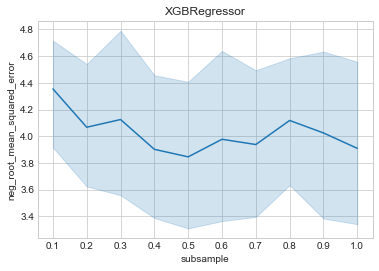

In [39]:
params = {'subsample': [n for n in np.arange(0.1, 1.1, 0.1)]}
xgb_subsample_scores, xgb_subsample_errors = assess_model_param(xgb, params, X_train, y_train)

Samples above 50% and particularly 90% seem best (similar to Random Forest)

**Max Features (colsample bytree)**: Features used for trees

XGBRegressor neg_root_mean_squared_error
colsample_bytree 0.25:	-5.817 (std 1.398) | train err: 0.957, test err: 2.892
colsample_bytree 0.5:	-6.267 (std 1.691) | train err: 0.395, test err: 2.720
colsample_bytree 0.75:	-4.640 (std 1.090) | train err: 0.274, test err: 2.249
colsample_bytree 1.0:	-3.909 (std 1.041) | train err: 0.197, test err: 1.878


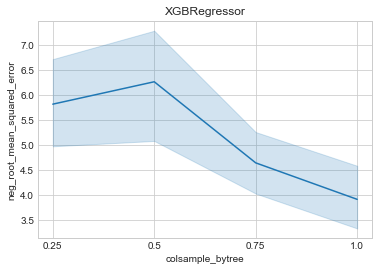

In [40]:
params = {'colsample_bytree': [n for n in np.arange(0.25, 1.1, 0.25)]}
xgb_colsampletree_scores, xgb_colsampletree_errors = assess_model_param(xgb, params, X_train, y_train)

All features are best 75% may be worth exploring

**Gamma**
- Gamma specifies the minimum loss reduction required to make a split.
- It makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
- The larger gamma is, the more conservative the algorithm will be.

XGBRegressor neg_root_mean_squared_error
gamma 0:	-3.909 (std 1.041) | train err: 0.197, test err: 1.878
gamma 200:	-3.641 (std 0.955) | train err: 1.486, test err: 2.068
gamma 400:	-3.759 (std 1.017) | train err: 1.641, test err: 2.147
gamma 600:	-3.823 (std 1.060) | train err: 1.769, test err: 2.247
gamma 800:	-3.913 (std 1.088) | train err: 1.829, test err: 2.333


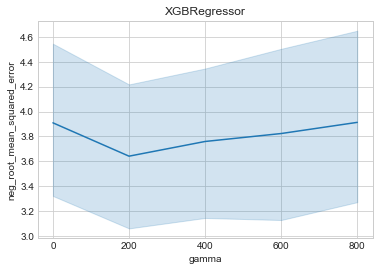

In [41]:
params = {'gamma': [n for n in range(0, 1000, 200)]}
xgb_minsamplesleaf_scores, xgb_minsamplesleaf_errors = assess_model_param(xgb, params, X_train, y_train)

Gamma between 200 and 400 seems best here, but good to optimise

**L1 Regularisation**: 

XGBRegressor neg_root_mean_squared_error
reg_alpha 1:	-3.902 (std 0.965) | train err: 0.245, test err: 1.933
reg_alpha 51:	-3.670 (std 0.983) | train err: 1.239, test err: 2.006
reg_alpha 101:	-3.957 (std 1.005) | train err: 1.453, test err: 2.038
reg_alpha 151:	-4.020 (std 1.059) | train err: 1.578, test err: 2.200
reg_alpha 201:	-4.222 (std 1.199) | train err: 1.665, test err: 2.234
reg_alpha 251:	-4.476 (std 1.336) | train err: 1.755, test err: 2.380


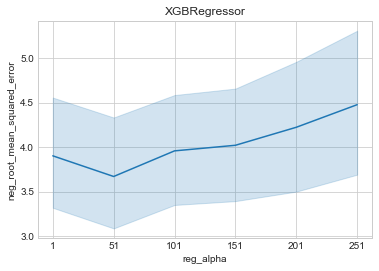

In [42]:
params = {'reg_alpha': [n for n in range(1, 300, 50)]}
xgb_l1reg_scores, xgb_l1reg_errors = assess_model_param(xgb, params, X_train, y_train)

L1 regularisation of around 100 looks like a good range for this problem. Optimise

**L2 Regularisation**: 

XGBRegressor neg_root_mean_squared_error
reg_lambda 0:	-4.202 (std 1.093) | train err: 0.130, test err: 1.934
reg_lambda 50:	-3.521 (std 0.908) | train err: 0.855, test err: 1.988
reg_lambda 100:	-3.551 (std 0.856) | train err: 1.002, test err: 2.021
reg_lambda 150:	-3.708 (std 0.949) | train err: 1.131, test err: 2.054
reg_lambda 200:	-3.937 (std 1.095) | train err: 1.221, test err: 2.119
reg_lambda 250:	-4.203 (std 1.235) | train err: 1.288, test err: 2.179


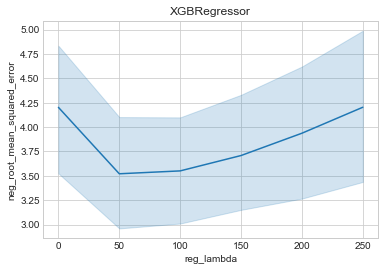

In [43]:
params = {'reg_lambda': [n for n in range(0, 300, 50)]}
xgb_l2reg_scores, xgb_l2reg_errors = assess_model_param(xgb, params, X_train, y_train)

L2 regularisation of around 100 looks like a good range for this problem. Optimise

### Hyperparameter Tuning

Experiment with scikit-optimize

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 13.7887
Function value obtained: 3.4322
Current minimum: 3.4322
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 19.0352
Function value obtained: 3.4509
Current minimum: 3.4322
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 2.4502
Function value obtained: 3.5537
Current minimum: 3.4322
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 16.2075
Function value obtained: 3.8891
Current minimum: 3.4322
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 4.7910
Function value obtained: 4.9

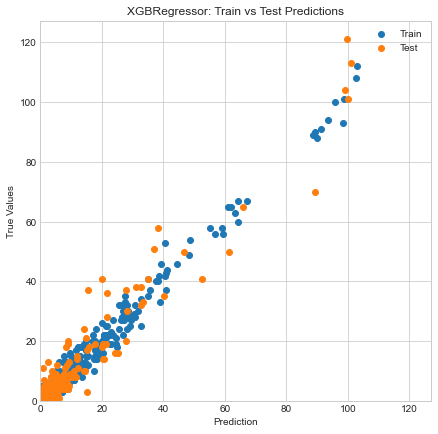

In [44]:
# initiate model
xgb_tune = XGBRegressor(max_depth=6,
                        min_child_weight=6,
                        subsample=1.,
                        colsample_bytree=1.,
                        gamma=2.6,
                        reg_alpha=11.4,
                        reg_lambda=5.8,
                        learning_rate=0.0026,
                        n_estimators=1400,
                        random_state=random_seed)

# set search parameters
# search_spaces = {'max_depth': (2, 20),
#                  'min_child_weight': (1.0, 20.0, 'uniform')}
search_spaces = {'learning_rate': (.001, 1., 'log-uniform'), 
                 'n_estimators': (50, 1500)}

# initialise tuner
cv = k_fold
tuner_man = BayesSearchCV(estimator=xgb_tune,
                          search_spaces=search_spaces,
                          scoring=error_score,
                          n_iter=100,
                          cv=cv,
                          n_jobs=-1,
                          verbose=0,
                          random_state=random_seed)

# fit tuner
t1 = time.time()
tuner_man.fit(X=X_train,
              y=y_train,
              callback=[VerboseCallback(n_total=50), DeltaYStopper(n_best=5, delta=0.02)])
# DeltaYStopper(n_best=5, delta=0.05)

# print results
xgb_tune_best = tuner_man.best_estimator_
xgb_tune_err_train, xgb_tune_err_test = train_test_error(xgb_tune_best, X_train, y_train, X_test, y_test, scoring=error_score)
print(f'\nSearch Time: {time.strftime("%H:%M:%S", time.gmtime(time.time()-t1))}')
print((f'Initial Cross Val Score ({cv}):\t{xgb_cv:.3f}\n'
       f'Tuned Cross Val Score ({cv}):\t{tuner_man.best_score_:.3f}\n'
       f'Initial Error:\tTrain: {xgb_initial_err_train:.3f}\tTest: {xgb_initial_err_test:.3f}\n'
       f'Tuned Error:\tTrain: {xgb_tune_err_train:.3f}\tTest: {xgb_tune_err_test:.3f}\n'))
print(tuner_man.best_params_)

model_fit_plot(xgb_tune_best, X_train, y_train, X_test, y_test)

C:\Users\tmais\AppData\Local\Temp/ipykernel_26316/3121556744.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oly[model_name_col] = xgb_best.predict(oly[features])
C:\Users\tmais\AppData\Local\Temp/ipykernel_26316/3121556744.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oly[model_name_col] = oly[model_name_col].astype('int')


XGBRegressor Best Model (neg_root_mean_squared_error)
Initial Cross Val Score (KFold(n_splits=10, random_state=0, shuffle=True)):	-3.937
Tuned Cross Val Score (KFold(n_splits=10, random_state=0, shuffle=True)):	-3.560
Initial Error:	Train: 0.305	Test: 3.712
Tuned Error:	Train: 2.391	Test: 3.863



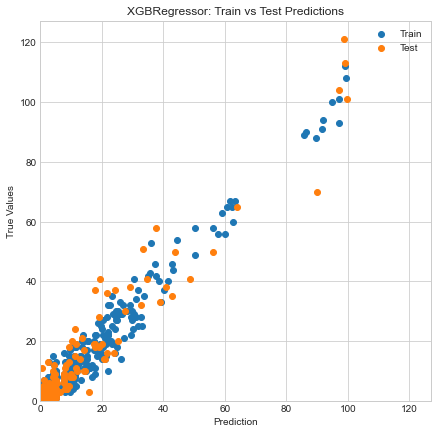

In [46]:
# initiate model
xgb_best = XGBRegressor(max_depth=5,
                        min_child_weight=5,
                        subsample=.95,
                        colsample_bytree=1.,
                        gamma=200,
                        reg_alpha=1,
                        reg_lambda=0,
                        learning_rate=0.05,
                        n_estimators=500,
                        random_state=random_seed)

# cross validate
cv = k_fold
xgb_best_cv = np.mean(cross_val_score(xgb_best,
                                      X=X_train,
                                      y=y_train,
                                      scoring=error_score,
                                      n_jobs=-1,
                                      cv=cv))

xgb_best.fit(X=X_train, y=y_train)
# xgb_best.fit(X=oly[features], y=oly[target]) # train on the whole dataset

# store results
model_name_col = 'xgboost'
oly[model_name_col] = xgb_best.predict(oly[features])
oly[model_name_col] = oly[model_name_col].astype('int')

# calc train/test scores
xgb_best_err_train, xgb_best_err_test = train_test_error(xgb_best, X_train, y_train, X_test, y_test, scoring=error_score)
print((f'{model_name} Best Model ({error_score})\n'
       f'Initial Cross Val Score ({cv}):\t{xgb_cv:.3f}\n'
       f'Tuned Cross Val Score ({cv}):\t{xgb_best_cv:.3f}\n'
       f'Initial Error:\tTrain: {xgb_initial_err_train:.3f}\tTest: {xgb_initial_err_test:.3f}\n'
       f'Tuned Error:\tTrain: {xgb_best_err_train:.3f}\tTest: {xgb_best_err_test:.3f}\n'))

model_fit_plot(xgb_best, X_train, y_train, X_test, y_test)

**Note:** This model is overfitted on the train-test split data, but has a good test score compared to other models.

In [47]:
xgb_best.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1.0,
 'enable_categorical': False,
 'gamma': 200,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 500,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 1,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 0.95,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

### Feature Importance

**Permutation Importance:** This approach is more reliable for high cardinality features but is slower to compute.

Text(0.5, 1.0, 'Tuned XGBRegressor: Permutations Feature Importances')

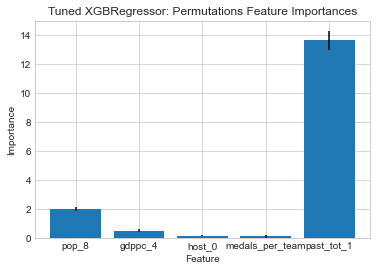

In [48]:
result = permutation_importance(xgb_best, 
                                X_test, 
                                y_test, 
                                n_repeats=10, 
                                scoring=error_score,
                                random_state=random_seed, 
                                n_jobs=-1)
plt.bar(features, result.importances_mean, yerr=result.importances_std)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Tuned {model_name}: Permutations Feature Importances')

Again, population comes out on top. GDP per capita is close to population. Medals per team is weighted higher than being host nation interestingly.

### Predictions vs Data

100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:47<00:00,  3.48it/s]


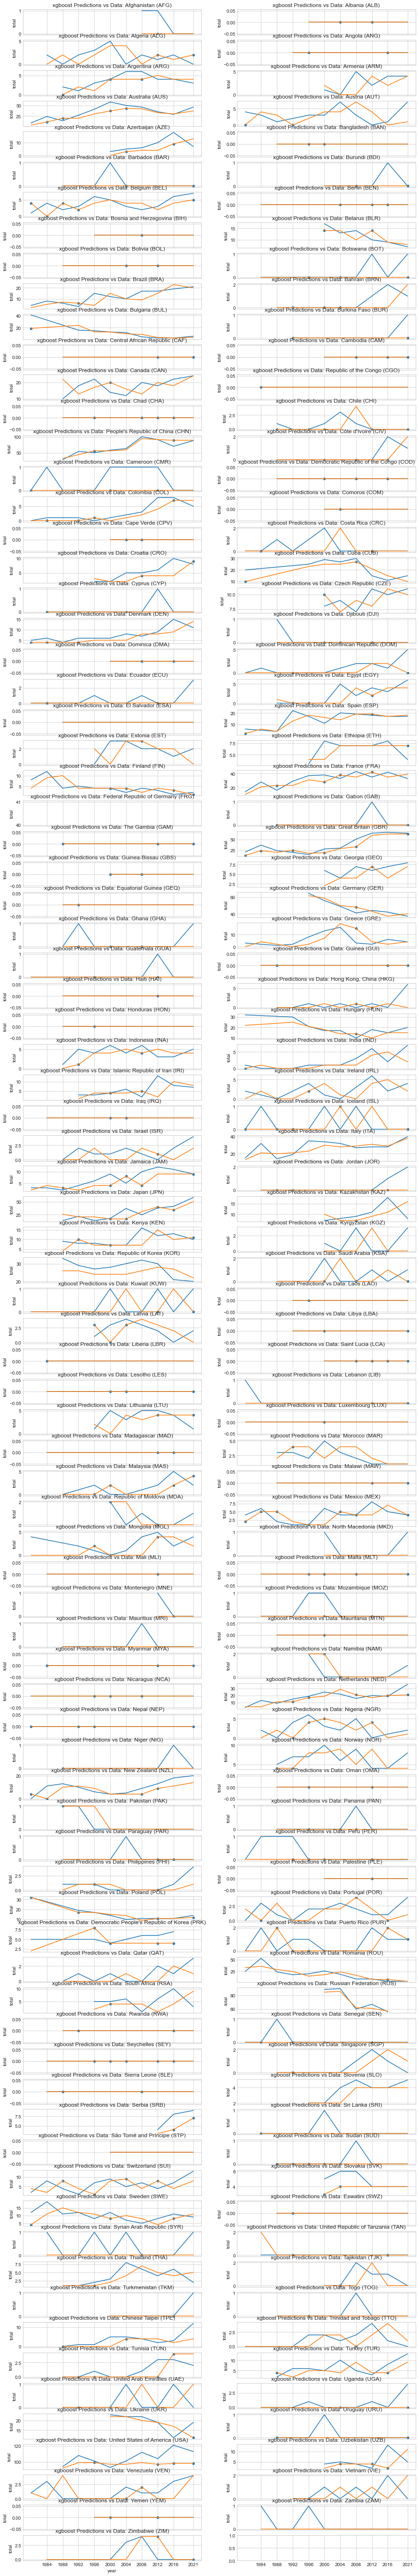

In [49]:
ioc_codes = [a3 for a3 in oly.ioc_code.sort_values().unique()]
width = 2
fig, ax = plt.subplots(ceil(len(ioc_codes)/width), width, figsize=(15,100), sharex=True)
ax = [item for sublist in ax for item in sublist]

with pd.option_context('mode.chained_assignment', None):
    for i, ioc_code in enumerate(tqdm(ioc_codes)):
        df = oly.loc[oly.ioc_code==ioc_code, ['games', 'country', 'ioc_code', 'year', 'total', 'test', model_name_col]]

        sns.lineplot(data=df, x='year', y='total', ax=ax[i])
        sns.lineplot(data=df, x='year', y=model_name_col, ax=ax[i])
        sns.scatterplot(data=df[df.test==1], x='year', y=model_name_col, ax=ax[i])
        #a = ax[i].set_xticklabels(oly[oly.alpha_3==alpha_3].games.unique(), rotation=45, ha='right')
        title = f'{model_name_col} Predictions vs Data: {oly[oly.ioc_code==ioc_code].country.unique()[0]} '
        title = title + f'({oly[oly.ioc_code==ioc_code].ioc_code.unique()[0]})'
        ax[i].set_xticks(df.year.sort_values().unique())
        ax[i].set_title(title)
        plt.legend(['Data', 'Predictions', 'is_test'])

100%|████████████████████████████████████████████████████████████████████████████████| 166/166 [00:45<00:00,  3.64it/s]


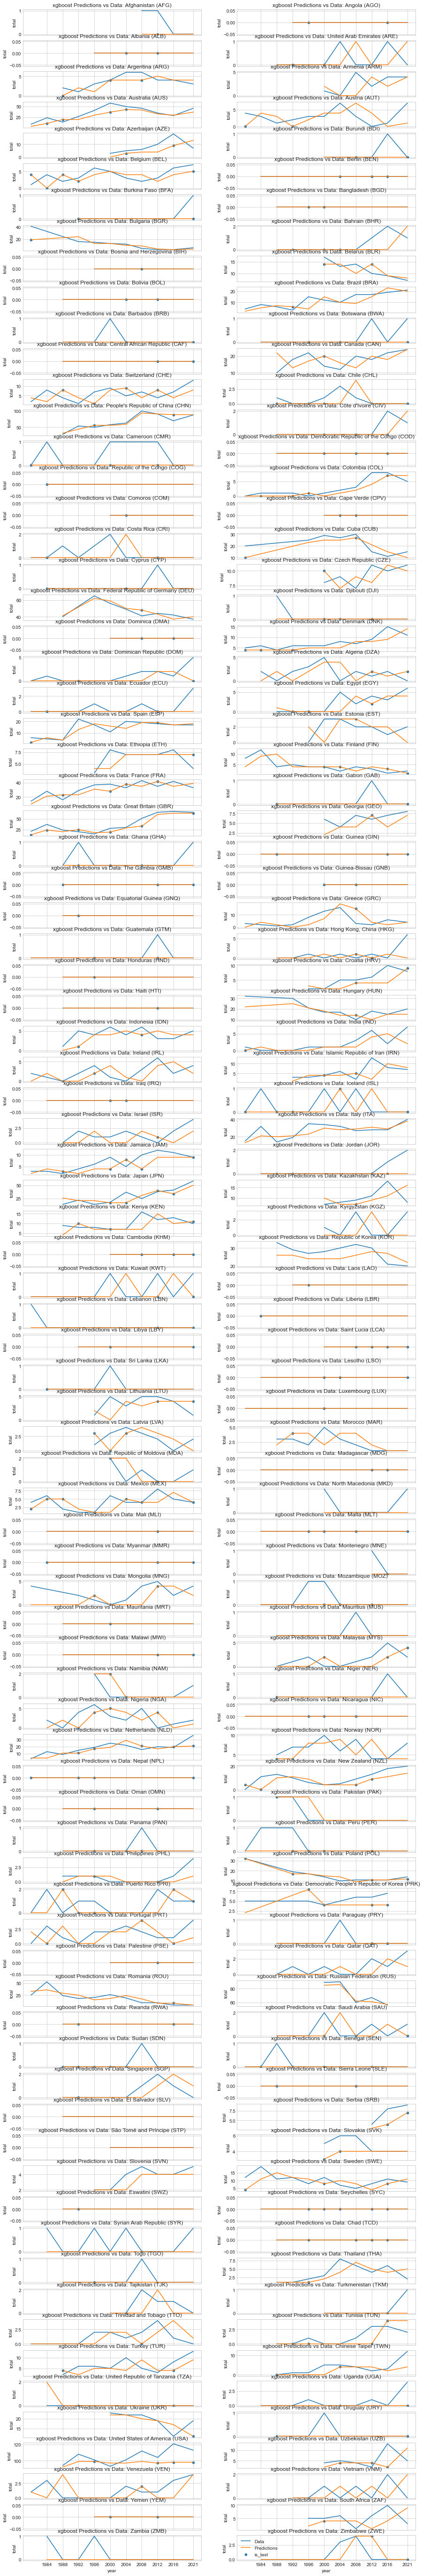

In [50]:
#alpha_3s = ['GBR', 'USA', 'CHN', 'NZL', 'EGY', 'ARG', 'AUS', 'AUT', 'BRA', 'GRC', 'JPN', 'DNK', 'ESP', 'ITA', 'PAN', 'NOR']
alpha_3s = [a3 for a3 in oly.alpha_3.sort_values().unique()]
width = 2
fig, ax = plt.subplots(ceil(len(alpha_3s)/width), width, figsize=(15,100), sharex=True)
ax = [item for sublist in ax for item in sublist]

with pd.option_context('mode.chained_assignment', None):
    for i, alpha_3 in enumerate(tqdm(alpha_3s)):
        df = oly.loc[oly.alpha_3==alpha_3, ['games', 'country', 'ioc_code', 'year', 'total', 'test', model_name_col]]

        sns.lineplot(data=df, x='year', y='total', ax=ax[i])
        sns.lineplot(data=df, x='year', y=model_name_col, ax=ax[i])
        sns.scatterplot(data=df[df.test==1], x='year', y=model_name_col, ax=ax[i])
        #a = ax[i].set_xticklabels(oly[oly.alpha_3==alpha_3].games.unique(), rotation=45, ha='right')
        title = f'{model_name_col} Predictions vs Data: {oly[oly.alpha_3==alpha_3].country.unique()[0]} '
        title = title + f'({oly[oly.alpha_3==alpha_3].alpha_3.unique()[0]})'
        ax[i].set_xticks(df.year.sort_values().unique())
        ax[i].set_title(title)
        plt.legend(['Data', 'Predictions', 'is_test'])

C:\Users\tmais\AppData\Local\Temp/ipykernel_26316/1576041381.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax.set_xticklabels(oly[oly.ioc_code==ioc_code_one].games.unique(), rotation=45, ha='right')


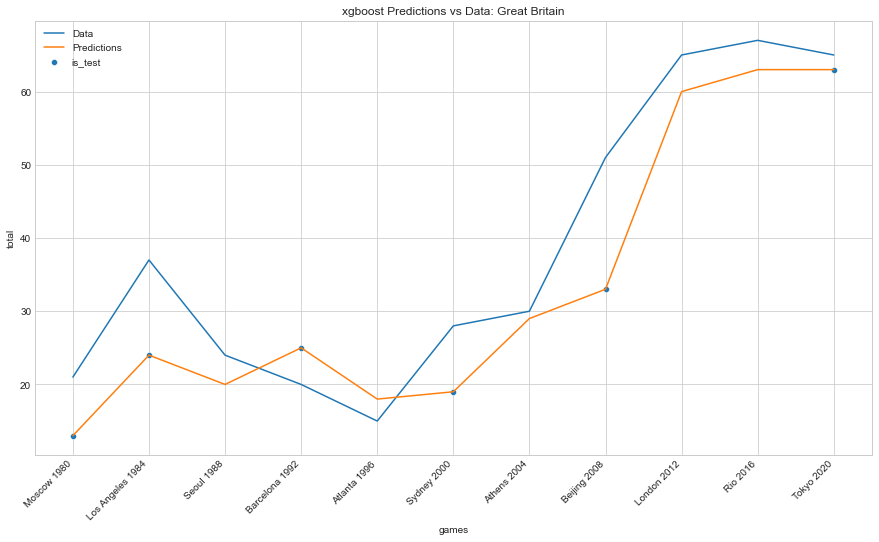

In [51]:
with pd.option_context('mode.chained_assignment', None):
    ioc_code_one = 'GBR'
    df = oly.loc[oly.ioc_code==ioc_code_one, ['games', 'country', 'ioc_code', 'year', 'total', 'test', model_name_col]]

    fig, ax = plt.subplots(figsize=(15,8))
    sns.lineplot(data=df, x='games', y='total', ax=ax)
    sns.lineplot(data=df, x='games', y=model_name_col, ax=ax)
    sns.scatterplot(data=df[df.test==1], x='games', y=model_name_col, ax=ax)
    a = ax.set_xticklabels(oly[oly.ioc_code==ioc_code_one].games.unique(), rotation=45, ha='right')
    plt.title(f'{model_name_col} Predictions vs Data: {oly[oly.ioc_code==ioc_code_one].country.unique()[0]}')
    plt.legend(['Data', 'Predictions', 'is_test'])

In [52]:
oly.loc[oly.ioc_code==ioc_code_one, ['games', 'country', 'alpha_3', 'year'] + features + [target, 'test', 'xgboost']]

,games,country,alpha_3,year,pop_8,gdppc_4,host_0,medals_per_team,past_tot_1,total,test,xgboost
1046,Moscow 1980,Great Britain,GBR,1980,56079.0,19311.00,0,7.790123,13.0,21,1,13
1150,Los Angeles 1984,Great Britain,GBR,1984,56206.0,20612.00,0,4.914286,21.0,37,1,24
1300,Seoul 1988,Great Britain,GBR,1988,56314.0,21869.00,0,4.618750,37.0,24,0,20
1463,Barcelona 1992,Great Britain,GBR,1992,56462.0,25679.00,0,4.822485,24.0,20,1,25
1643,Atlanta 1996,Great Britain,GBR,1996,57160.0,25790.18,0,4.274112,20.0,15,0,18
1840,Sydney 2000,Great Britain,GBR,2000,57828.0,28472.25,0,4.611940,15.0,28,1,19
2042,Athens 2004,Great Britain,GBR,2004,58417.0,31946.04,0,4.584158,28.0,30,0,29
2243,Beijing 2008,Great Britain,GBR,2008,59145.0,34865.78,0,4.691176,30.0,51,1,33
2448,London 2012,Great Britain,GBR,2012,60245.0,36264.79,1,4.613527,51.0,65,0,60
2655,Rio 2016,Great Britain,GBR,2016,62072.0,35185.00,0,4.677885,65.0,67,0,63


In [53]:
oly.alpha_3.sort_values().unique()

array(['AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE',
       'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR',
       'BOL', 'BRA', 'BRB', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CUB',
       'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU',
       'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO',
       'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GTM', 'HKG', 'HND',
       'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL',
       'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM',
       'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO',
       'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MEX', 'MKD', 'MLI',
       'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS',
       'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN',
       'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRI', 'PRK', 'PRT', 'PRY',
       'PSE', 'QAT',

In [54]:
features

['pop_8', 'gdppc_4', 'host_0', 'medals_per_team', 'past_tot_1']

In [55]:
X = pd.DataFrame({'pop_8': [65610.], 'gdppc_4': [40217.], 'host_0': [0], 'medals_per_team': [4.79], 'past_tot_1': [65.]})
# X=[[65610., 40318., 0, 5., 65.],]
int(xgb_best.predict(X))

64

In [56]:
3*329/206

4.79126213592233